# Evalution and Analysis

## Imports:

In [1]:
from pathlib import Path

## Get predictions and metrics:

In [2]:
from Helper.evaluation_helpers import get_predictions, calc_metrics

## Supress warnings

In [3]:
import warnings
warnings.filterwarnings("ignore") 

In [4]:
predsPath= Path('../Predictions/')
predsDf=get_predictions(predsPath)
display(predsDf)

,ground_truth,ARDL,ARIMA1990,ARIMA2000,ARIMAX1990,ARIMAX2000,GRU,MLR,Naive,NBEATSx,NHITS,SARIMA1990,SARIMA2000,SARIMAX1990,SARIMAX2000,Tide
observation_date,,,,,,,,,,,,,,,,
01/2024,122.115,105.785040,121.865489,121.865276,122.032167,122.041159,104.798742,106.121323,105.69,105.880539,106.287415,121.830877,121.825091,122.027723,122.034905,116.734955
02/2024,122.494,105.785040,122.135733,122.162382,122.355127,122.365015,104.614738,106.247963,105.69,105.993225,106.401459,122.078725,122.064401,122.345566,122.354341,117.139011
03/2024,122.912,105.785040,122.405977,122.474494,122.703658,122.715848,104.392772,106.374603,105.69,106.098434,106.361130,122.329628,122.305672,122.681395,122.693973,117.880245
04/2024,123.234,105.860227,122.676221,122.793262,122.981567,122.997314,104.176452,106.501243,105.69,106.191010,106.385925,122.615530,122.588610,122.970076,123.000487,117.525977
05/2024,123.224,106.270458,122.946465,123.114981,123.022006,123.032635,103.988449,106.627884,105.69,106.291138,106.396194,122.893196,122.859555,123.013217,123.031498,115.863418
06/2024,123.369,106.605603,123.216709,123.438010,123.173677,123.182241,103.839441,106.754524,105.69,106.396713,106.481056,123.105805,123.057705,123.143869,123.143131,118.537720
07/2024,123.575,106.960277,123.486953,123.761619,123.368604,123.376724,103.721934,106.881164,105.69,106.486832,106.481674,123.456398,123.410391,123.373764,123.376777,121.986087
08/2024,123.727,107.328459,123.757197,124.085487,123.524688,123.531221,103.626826,107.007804,105.69,106.595963,106.550713,123.746242,123.696499,123.544405,123.542442,121.411090
09/2024,123.939,107.671517,124.027441,124.409468,123.723146,123.729655,103.544718,107.134444,105.69,106.687790,106.595749,124.029698,123.976322,123.754089,123.748122,119.570833


# Calculate Metrics:

In [5]:
# metric DataFrames are sorted by the main metric before being displayed
main_metric = 'RMSE'

## Horizon = 1

In [6]:
# WARNING: r2 is not well defined for less than 2 samples
metrics_1= calc_metrics(predsDf, horizon=1).drop('r2', axis=1)
display(metrics_1.sort_values(main_metric, axis=0))

,RMSE,MAE
ARIMAX2000,0.073841,0.073841
SARIMAX2000,0.080095,0.080095
ARIMAX1990,0.082833,0.082833
SARIMAX1990,0.087277,0.087277
ARIMA1990,0.249511,0.249511
ARIMA2000,0.249724,0.249724
SARIMA1990,0.284123,0.284123
SARIMA2000,0.289909,0.289909
Tide,5.380045,5.380045
NHITS,15.827585,15.827585


## Horizon = 3

In [7]:
metrics_3= calc_metrics(predsDf, horizon=3)
display(metrics_3.sort_values(main_metric, axis=0))

,RMSE,MAE,r2
ARIMAX2000,0.142086,0.132992,0.809459
ARIMAX1990,0.152265,0.14335,0.781181
SARIMAX2000,0.156477,0.145927,0.768904
SARIMAX1990,0.166161,0.155439,0.739415
ARIMA2000,0.348207,0.339616,-0.14436
ARIMA1990,0.385863,0.371267,-0.40525
SARIMA1990,0.444348,0.427257,-0.863526
SARIMA2000,0.46052,0.441945,-1.001638
Tide,5.257989,5.255596,-259.932094
NHITS,16.159761,16.156999,-2463.665514


## Horizon = 6

In [8]:
metrics_6= calc_metrics(predsDf, horizon=6)
display(metrics_6.sort_values(main_metric, axis=0))

,RMSE,MAE,r2
ARIMAX2000,0.177052,0.168964,0.845484
ARIMAX1990,0.188073,0.179966,0.825649
SARIMAX2000,0.189762,0.181611,0.822503
SARIMAX1990,0.203141,0.194359,0.796592
ARIMA2000,0.309473,0.272936,0.527917
ARIMA1990,0.378155,0.350234,0.295126
SARIMA1990,0.438472,0.415707,0.052333
SARIMA2000,0.462329,0.441161,-0.053598
Tide,5.672159,5.611112,-157.587577
MLR,16.455364,16.45341,-1333.711434


## Horizon = 12

In [9]:
metrics_12= calc_metrics(predsDf, horizon=12)
display(metrics_12.sort_values(main_metric, axis=0))

,RMSE,MAE,r2
SARIMAX2000,0.192264,0.188029,0.931423
SARIMAX1990,0.197643,0.193021,0.927532
ARIMAX2000,0.20632,0.199334,0.921029
ARIMAX1990,0.215431,0.208694,0.9139
ARIMA1990,0.278222,0.22374,0.856396
SARIMA1990,0.33694,0.285122,0.789385
SARIMA2000,0.344726,0.28355,0.779538
ARIMA2000,0.419849,0.374905,0.672983
Tide,5.166663,4.877586,-48.52271
ARDL,16.620795,16.616828,-511.492721


# Analysis:

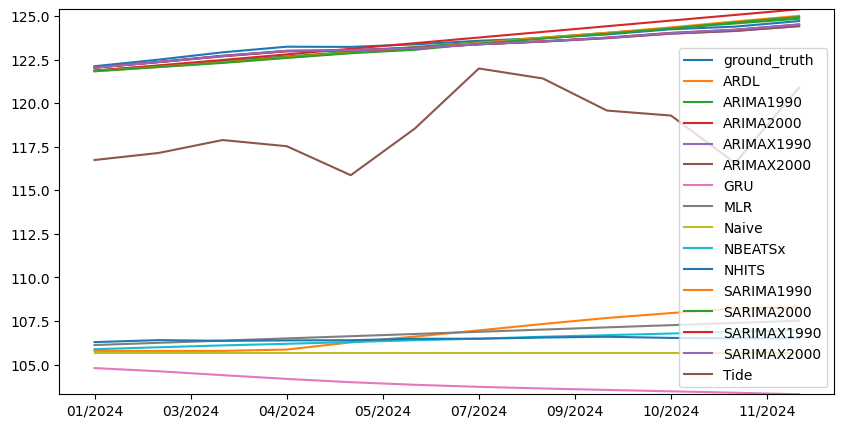

In [10]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.locator_params(axis='x', nbins=10)

for model in predsDf.columns:
    plt.plot(predsDf.index, predsDf[model])

plt.ylim(predsDf.drop('ARDL', axis=1).min(axis=0).min(), predsDf.drop('ARDL', axis=1).max(axis=0).max())
plt.legend(predsDf.columns)
plt.show()

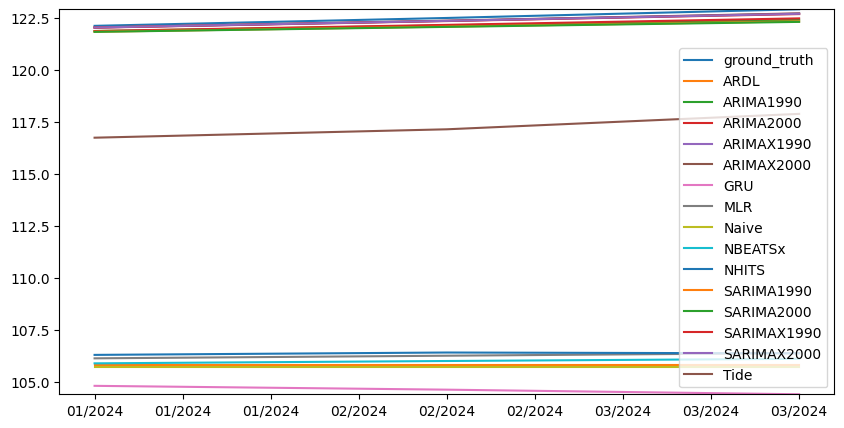

In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.locator_params(axis='x', nbins=10)

for model in predsDf.columns:
    plt.plot(predsDf.index[:int(len(predsDf)/4)], predsDf[model][:int(len(predsDf)/4)])

plt.ylim(predsDf[:int(len(predsDf)/4)].drop('ARDL', axis=1).min(axis=0).min(), predsDf[:int(len(predsDf)/4)].drop('ARDL', axis=1).max(axis=0).max())
plt.legend(predsDf.columns)
plt.show()